In [6]:
# load the autoreload extension
%reload_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

import numpy as np
import joblib
import os
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
vpf_path = '/mnt/data4/Abhishek/fidmock/vpf'

vpf_filenames = ['vpf_subsample_'+f'{files:04d}'+'.npy' for files in range(100)]
vpf = []
for files in vpf_filenames:
    sample = np.load(os.path.join(vpf_path,files))
    vpf.append(sample[1])
vpf_z = np.vstack(vpf).T  
vpf_filenames = ['vpf_subsample_'+f'{files:04d}'+'.npy' for files in range(100,200)]
vpf = []
for files in vpf_filenames:
    sample = np.load(os.path.join(vpf_path,files))
    vpf.append(sample[1])
vpf_x = np.vstack(vpf).T 
vpf_filenames = ['vpf_subsample_'+f'{files:04d}'+'.npy' for files in range(200,300)]
vpf = []
for files in vpf_filenames:
    sample = np.load(os.path.join(vpf_path,files))
    vpf.append(sample[1])
vpf_y = np.vstack(vpf).T 


vpfz_cov = np.cov(vpf_z)
vpfx_cov = np.cov(vpf_x)
vpfy_cov = np.cov(vpf_y)
vpf_cov = (vpfz_cov + vpfx_cov + vpfy_cov)/3

In [3]:
filename = 'vpf_model.sav'
# load the model from disk
model = joblib.load(filename)
vpf_data = np.load('/mnt/data4/Abhishek/VPF/random/vpf_galaxies_0000.npy')[1]

In [4]:
vpf_data.shape

(30,)

In [5]:
x_test = np.array([13.088658, 14.060000, 0.980000, 1.130000, 0.900000])

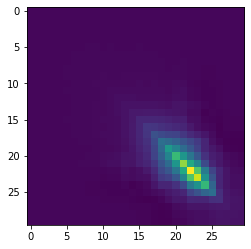

In [7]:
plt.imshow(vpf_cov)

In [8]:
def vpf_model(par):
    result = model.predict(par.reshape(1,-1))
    return result[0]

In [9]:
def log_likelihood(par , data, cov):
    M_cut,M1 ,sigma, kappa, alpha = par
    diff = data - vpf_model(par)
    return  -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [10]:
def log_prior(par):
    M_cut,M1 ,sigma, kappa, alpha = par
    if 12.0 < M_cut < 15.0 and 12.0 < M1 < 15.0 and 1e-8 < sigma < 5.0 and 1e-8 < kappa < 5.0 and 1e-8 < alpha < 5.0:
        return 0.0
    return -np.inf

In [11]:
def log_probability(par, data, cov):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(par, data, cov)

In [12]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = x_test + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=(vpf_data, vpf_cov))
M_cut_ml,M1_ml,sigma_ml, kappa_ml, alpha_ml = soln.x

In [13]:
soln.x

array([13.14704886, 14.05117082,  1.05185847,  1.2911414 ,  0.87687625])

In [19]:
import emcee
ndim = 5
nwalkers = 150
pos = soln.x + 1e-4 * np.random.rand(nwalkers, ndim)

with Pool() as pool:
    filename = "vpfmcmctest.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vpf_data, vpf_cov),pool=pool,backend=backend)
    sampler.run_mcmc(pos, 300, progress=True)

100%|██████████| 300/300 [09:24<00:00,  1.63s/it]


Text(0.5, 0, 'step number')

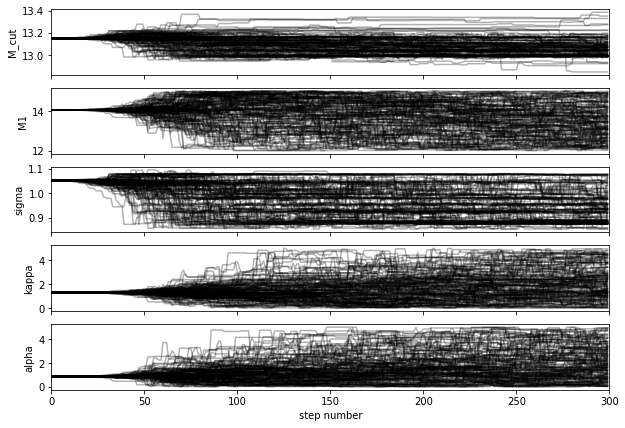

In [20]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["M_cut","M1" ,"sigma", "kappa", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [23]:
flat_samples = sampler.get_chain(discard=50, flat=True)
print(flat_samples.shape)

(37500, 5)


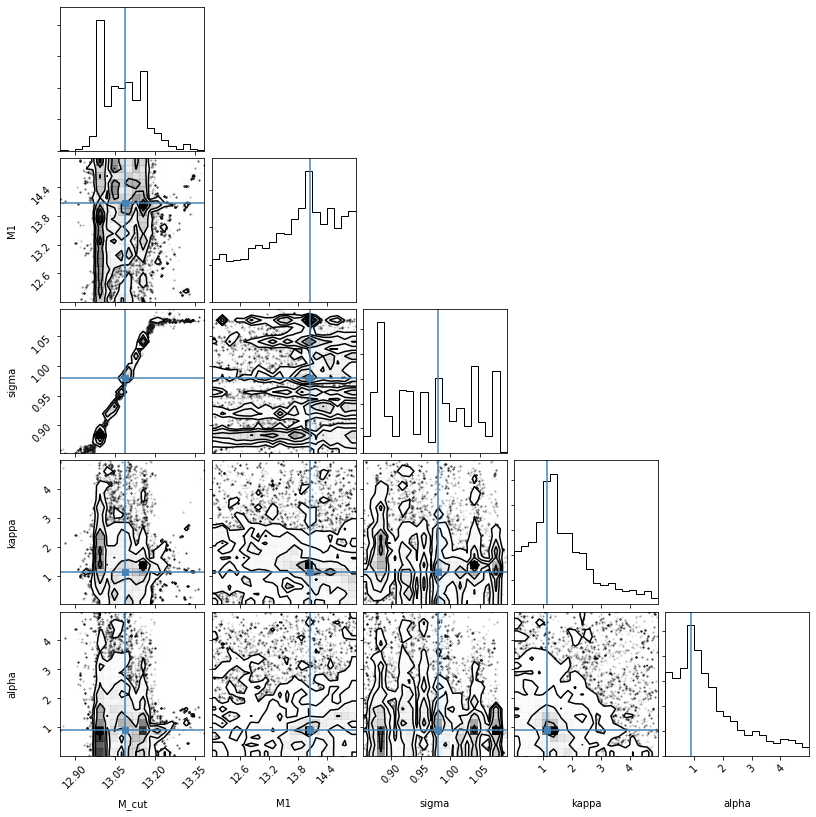

In [24]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=x_test
)